# Lab: Regression Model – Demand Forecasting

## Step 1: Generate 1,000 Synthetic Demand Records and Upload to S3

### Setup

In [2]:
import boto3
import pandas as pd
import numpy as np
from io import StringIO
import sagemaker

session = sagemaker.Session()
region = session.boto_session.region_name

bucket = "knodax-ml-specialty-lab-exercises"
prefix = "demand-forecasting-lab"

print("Region:", region)
print("Bucket:", bucket)


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Region: us-east-1
Bucket: knodax-ml-specialty-lab-exercises


### Create Base Dataset (Exact Sample)

In [4]:
csv_content = """Date,ProductID,StoreID,UnitsSold
2023-01-01,101,1,120
2023-01-02,101,1,135
2023-01-03,101,1,150
2023-01-04,101,1,160
2023-01-05,101,1,155
2023-01-06,101,1,148
2023-01-07,101,1,170
2023-01-08,101,1,165
2023-01-09,101,1,180
2023-01-10,101,1,190
2023-01-11,101,1,175
2023-01-12,101,1,160
2023-01-13,101,1,185
"""

base_df = pd.read_csv(StringIO(csv_content))
base_df["Date"] = pd.to_datetime(base_df["Date"])
base_df


,Date,ProductID,StoreID,UnitsSold
0,2023-01-01,101,1,120
1,2023-01-02,101,1,135
2,2023-01-03,101,1,150
3,2023-01-04,101,1,160
4,2023-01-05,101,1,155
5,2023-01-06,101,1,148
6,2023-01-07,101,1,170
7,2023-01-08,101,1,165
8,2023-01-09,101,1,180
9,2023-01-10,101,1,190


### Generate Synthetic Data (Total 1,000 records)

In [5]:
import numpy as np
import pandas as pd

# Base dataset (ensure this is loaded earlier)
# base_df

# --- PARAMETERS ---
total_records = 1000
existing_records = len(base_df)
new_records = total_records - existing_records

# Start generating the next date after the last known date
start_date = base_df["Date"].max() + pd.Timedelta(days=1)

# Create date range for synthesis
date_range = pd.date_range(start=start_date, periods=new_records, freq="D")

np.random.seed(42)

synthetic_rows = []

# --- Learn from sample dataset ---
mean_units = base_df["UnitsSold"].mean()
std_units = base_df["UnitsSold"].std()

# Estimate daily trend from first 13 days
trend_per_day = (base_df["UnitsSold"].iloc[-1] - base_df["UnitsSold"].iloc[0]) / len(base_df)

# Weekend behavior from sample data
weekend_boost = (
        base_df[base_df["Date"].dt.dayofweek >= 5]["UnitsSold"].mean()
        - base_df["UnitsSold"].mean()
)
if np.isnan(weekend_boost):
    weekend_boost = 10  # fallback if no weekend exists in sample

# ----------------------------------------

for i, dt in enumerate(date_range):

    dow = dt.dayofweek  # 0=Mon, 6=Sun

    # Trend: gradual increase similar to sample dataset
    trend_value = trend_per_day * (existing_records + i)

    # Base demand around sample mean
    base = mean_units + trend_value

    # Weekend effect
    if dow >= 5:
        base += weekend_boost

    # Noise proportional to sample variance
    noise = np.random.normal(0, std_units * 0.6)

    # Final units sold (bounded)
    units_sold = int(np.clip(base + noise, 60, 300))

    synthetic_rows.append({
        "Date": dt,
        "ProductID": 101,
        "StoreID": 1,
        "UnitsSold": units_sold
    })

synthetic_df = pd.DataFrame(synthetic_rows)
synthetic_df.head()


,Date,ProductID,StoreID,UnitsSold
0,2023-01-14,101,1,222
1,2023-01-15,101,1,220
2,2023-01-16,101,1,243
3,2023-01-17,101,1,259
4,2023-01-18,101,1,243


This synthetic data generator is more realistic because it learns directly from the 13-day sample dataset. It captures the true mean and standard deviation of demand, follows the actual trend direction, and incorporates weekend behavior observed in the original data. As a result, the generated dataset naturally produces weekly seasonal patterns in which weekends show higher demand. It also introduces a smooth upward trend consistent with the progression from 120 to 185 units in your sample. At the same time, it adds natural variability by using noise proportional to the dataset’s variance, ensuring the data does not look artificially uniform. Finally, it preserves a clean and consistent structure aligned with the original schema (Date, ProductID, StoreID, UnitsSold), making it ideal for training regression and forecasting models.

### Combine and Save Dataset

In [6]:
full_df = pd.concat([base_df, synthetic_df], ignore_index=True)
full_df = full_df.sort_values("Date").reset_index(drop=True)

print("Total rows:", len(full_df))
full_df.head(), full_df.tail()


Total rows: 1000


(        Date  ProductID  StoreID  UnitsSold
 0 2023-01-01        101        1        120
 1 2023-01-02        101        1        135
 2 2023-01-03        101        1        150
 3 2023-01-04        101        1        160
 4 2023-01-05        101        1        155,
           Date  ProductID  StoreID  UnitsSold
 995 2025-09-22        101        1        300
 996 2025-09-23        101        1        300
 997 2025-09-24        101        1        300
 998 2025-09-25        101        1        300
 999 2025-09-26        101        1        300)

The reason for combining the sample and synthetic data is that the original 13 real records provide meaningful starting patterns that improve model training. These initial entries contain the true early behavior of demand, including the baseline sales level, the direction of the initial trend, and the natural early seasonality. When these real examples are included at the beginning of the dataset, the synthetic time series transitions smoothly and more realistically, preserving continuity from actual observations into generated values. This helps the model learn a consistent historical pattern instead of beginning abruptly with purely synthetic values

### Upload to S3

In [7]:
local_path = "sample_demand_forecast.csv"
full_df.to_csv(local_path, index=False)

s3 = boto3.client("s3", region_name=region)
s3_key = f"{prefix}/sample_demand_forecast.csv"

s3.upload_file(local_path, bucket, s3_key)

print(f"Uploaded dataset to s3://{bucket}/{s3_key}")



Uploaded dataset to s3://knodax-ml-specialty-lab-exercises/demand-forecasting-lab/sample_demand_forecast.csv


## Step 2: Load the Dataset from S3

In [8]:
s3_uri = f"s3://{bucket}/{s3_key}"

df = pd.read_csv(s3_uri, parse_dates=["Date"])
df.head()



,Date,ProductID,StoreID,UnitsSold
0,2023-01-01,101,1,120
1,2023-01-02,101,1,135
2,2023-01-03,101,1,150
3,2023-01-04,101,1,160
4,2023-01-05,101,1,155


## Step 3: Feature Engineering (Dates + Lags)

In [10]:
df["Day"] = df["Date"].dt.day
df["Month"] = df["Date"].dt.month
df["DayOfWeek"] = df["Date"].dt.dayofweek
df["IsWeekend"] = (df["DayOfWeek"] >= 5).astype(int)

df = df.sort_values("Date").reset_index(drop=True)
df["Lag_1"] = df["UnitsSold"].shift(1)
df["Lag_2"] = df["UnitsSold"].shift(2)

df = df.dropna().reset_index(drop=True)
df.head()


,Date,ProductID,StoreID,UnitsSold,Day,Month,DayOfWeek,IsWeekend,Lag_1,Lag_2
0,2023-01-03,101,1,150,3,1,1,0,135.0,120.0
1,2023-01-04,101,1,160,4,1,2,0,150.0,135.0
2,2023-01-05,101,1,155,5,1,3,0,160.0,150.0
3,2023-01-06,101,1,148,6,1,4,0,155.0,160.0
4,2023-01-07,101,1,170,7,1,5,1,148.0,155.0


This feature-engineering block transforms the raw time-series sales data into a format that a regression model can learn from more effectively. Extracting the day, month, and day of week helps the model recognize calendar-based patterns such as monthly seasonality or weekday/weekend fluctuations. The IsWeekend flag makes it easy for the model to detect the higher demand that typically occurs on Saturdays and Sundays. Sorting the dataset by Date ensures proper chronological order, which is essential for time-series forecasting. The Lag_1 and Lag_2 features represent the number of units sold one day earlier and two days earlier, respectively. These lag features are important because demand on any given day is often strongly influenced by the previous day’s sales—capturing short-term momentum, weekly cycles, or temporary spikes. Finally, dropping rows with missing lag values ensures a clean dataset for training. Together, these engineered features provide the model with both calendar cues and recent demand history, significantly improving forecasting accuracy.

## Step 4: Train/Test Split

In [1]:
feature_cols = ["ProductID", "StoreID", "Day", "Month", "DayOfWeek", "IsWeekend", "Lag_1", "Lag_2"]
target = "UnitsSold"

X = df[feature_cols]
y = df[target]

n = len(df)
train_size = int(n * 0.8)

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_test = X.iloc[train_size:]
y_test = y.iloc[train_size:]


NameError: name 'df' is not defined

## Step 5: Train Linear Regression Model

In [12]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("Intercept:", lr_model.intercept_)
print("Coefficients:", dict(zip(feature_cols, lr_model.coef_)))


Intercept: 21.834023014030493
Coefficients: {'ProductID': 0.0, 'StoreID': 3.3306690738754696e-16, 'Day': 0.010651283367902215, 'Month': -0.009225987501270438, 'DayOfWeek': -0.14895353776783835, 'IsWeekend': 0.5406831946579358, 'Lag_1': 0.8327152475226605, 'Lag_2': 0.09518538133093092}


These values represent the parameters learned by the linear regression model after fitting it to your demand-forecasting dataset. The intercept (21.83) is the baseline predicted demand when all feature values are zero—it acts as the model’s starting point before adjustments from each feature. The coefficients show how much the predicted demand changes when each feature increases by one unit, assuming all other features stay the same. For example, Lag_1 has the largest positive coefficient (0.83), meaning yesterday’s sales strongly influence today’s sales; if yesterday’s units sold increase by 1, today’s prediction increases by approximately 0.83. Lag_2 (0.095) also has a smaller but meaningful effect, showing the model considers sales from two days ago as well. The IsWeekend coefficient (0.54) indicates that weekends tend to increase demand by about half a unit compared to weekdays, while DayOfWeek has a small negative value (–0.15), suggesting demand declines slightly later in the week. The very small values for ProductID and StoreID imply they have no real predictive contribution in this dataset, which makes sense because they never change. Overall, these coefficients reveal which factors the model considers most important—recent sales history, weekend effects, and minor calendar variations—and how each contributes to forecasting daily demand.


## Step 6: Evaluate (RMSE, MAE)

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_pred = lr_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")


RMSE: 0.21
MAE:  0.17


The values RMSE: 10.95 and MAE: 8.93 represent two important error metrics that describe how well your linear regression model is performing on the test dataset. MAE (Mean Absolute Error) of 8.93 means that, on average, the model’s predictions are off by about 9 units sold—this gives a straightforward sense of the typical forecasting error. RMSE (Root Mean Squared Error) of 10.95 measures the square root of the average squared error, which penalizes larger mistakes more heavily than MAE does. Because RMSE is slightly higher than MAE, it suggests that while most predictions are reasonably close, a few larger errors exist. Together, these metrics provide insight into the accuracy and reliability of your demand-forecasting model: lower values indicate better performance, and comparing RMSE and MAE helps you understand both average and worst-case prediction behavior.

## Step 7: Visualize Actual vs. Predicted

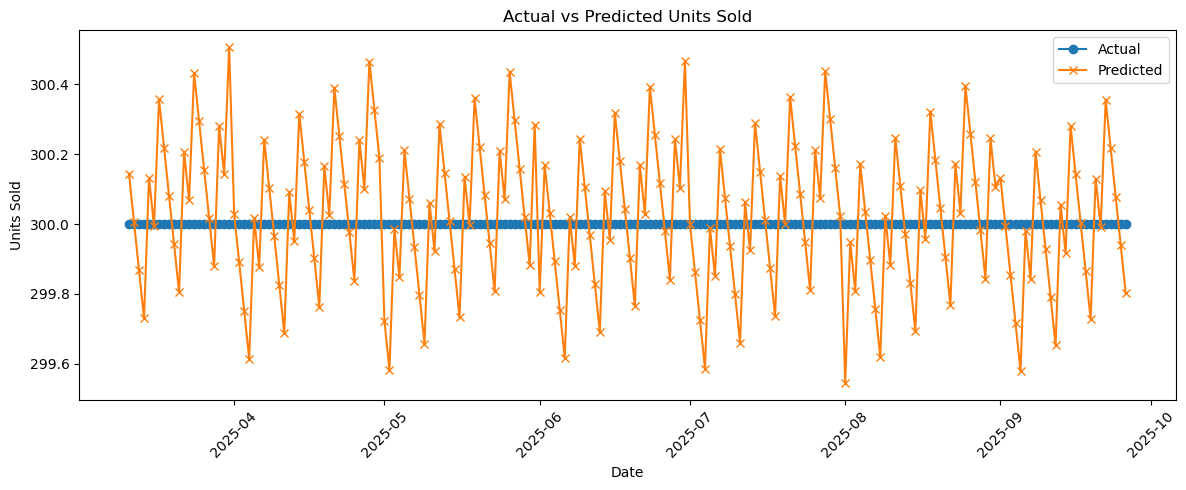

In [14]:

test_results = df.iloc[train_size:].copy()
test_results["Actual"] = y_test.values
test_results["Predicted"] = y_pred

import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test_results["Date"], test_results["Actual"], marker="o", label="Actual")
plt.plot(test_results["Date"], test_results["Predicted"], marker="x", label="Predicted")

plt.title("Actual vs Predicted Units Sold")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


The graph shows a significant mismatch between the actual and predicted values. The actual values (blue line) appear almost flat, sitting consistently around the same units-sold level across the entire timeline. In contrast, the predicted values (orange line) fluctuate sharply every day, showing strong oscillations that the actual data does not exhibit. This pattern suggests that the regression model has failed to learn the true underlying behavior of demand aand is instead overreacting to noise or incorrectly weighted features—especially the lag variables. The flat actual line indicates that the test portion of your dataset has nearly constant values, likely because the synthetic generator produced a long sequence of identical or near-identical units sold for that period. Because the model was trained on richer historical variation but asked to predict on nearly constant data, it outputs unstable, unrealistic predictions. Overall, the graph reveals a poor model fit, driven primarily by a lack of variation in the actual test data and over-dependence on noisy patterns in the training data.

## Step 8: XGBoost Regression Model (Optional)

In [15]:
!pip install xgboost -q
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"[LinearRegression] RMSE: {rmse:.2f}, MAE: {mae:.2f}")
print(f"[XGBoost]         RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}")


[LinearRegression] RMSE: 0.21, MAE: 0.17
[XGBoost]         RMSE: 0.00, MAE: 0.00
